In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [134]:
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from src.eval import get_accuracy_gaps, get_mae_feas
from src.model import get_model, get_C_GL, fix_c_gl, decode_fixing
from src.net import ObjSurrogate, Fixer
from src.utils import load_from_wandb
from src.dataset import EarlyFixingDataset, WellObjDataset

In [3]:
with open('../ef_objs.pkl', 'rb') as f:
    ef_objs = pickle.load(f)

wells = list(ef_objs.keys())

np.random.seed(42)
test_is = np.random.choice(len(wells), int(0.2 * len(wells)), replace=False)
test_wells = [wells[i] for i in test_is]
ef_objs_test = {w: ef_objs[w] for w in test_wells}

ds = EarlyFixingDataset(ef_objs_test)
len(ds)

10000

# Supervised

In [160]:
accs = list()
gapss = list()
model_ids = ['o7arihlb', 'jp24pkwb', 'm95c8k43', 'q103zyc1', 'mlnju8dq']
for mid in model_ids:
    fixer = load_from_wandb(Fixer(layers=[25, 25]), mid, 'gef-fs')
    fixer.eval()

    acc, gaps = get_accuracy_gaps(fixer, ds)
    accs.append(acc)
    gapss.append(gaps)

all_gaps = list()
for gaps in gapss:
    all_gaps += gaps
inf_miss = sum(g < 0 for g in all_gaps) / (5 * len(ds))

pos_gaps = [g for g in all_gaps if g > 0]
avg_gap = sum(pos_gaps) / len(pos_gaps)

print('Accuracy = ', sum(accs) / 5)
print('Infeasible = ', inf_miss)
print('Gap = ', avg_gap)

100%|██████████| 10000/10000 [00:01<00:00, 5883.98it/s]


Accuracy =  0.99778
Infeasible =  0.00106
Gap =  0.08126123884977118


In [153]:
np.std(pos_gaps)

0.08560547912488121

# Semi-supervised

## Surrogate

In [137]:
surr_ds = WellObjDataset(ef_objs_test)

maes = list()
accs = list()
model_ids = ['2xz377hr', 'vswo49uu', 'tj3pelgm', 'sj73ephx', 'etpop2ab']
for mid in model_ids:
    surrogate = load_from_wandb(ObjSurrogate(layers=[10, 10, 10]), mid, 'gef-fs')
    surrogate.eval()

    mae, acc = get_mae_feas(surrogate, surr_ds)

    maes.append(mae)
    accs.append(acc)
sum(maes) / len(maes), sum(accs) / len(accs)

100%|██████████| 250000/250000 [00:49<00:00, 5087.45it/s]


(60.049558552683415, 0.7823184000000001)

## Fixer

In [161]:
accs = list()
gapss = list()
model_ids = ['jtf1baqr', '8x2wtn2c', 'r3gkwm67', 'zni5mpm3', 'xr36e99h']
for mid in model_ids:
    fixer = load_from_wandb(Fixer(layers=[25, 25]), mid, 'gef-fs')
    fixer.eval()

    acc, gaps = get_accuracy_gaps(fixer, ds)
    accs.append(acc)
    gapss.append(gaps)

all_gaps = list()
for gaps in gapss:
    all_gaps += gaps
inf_miss = sum(g < 0 for g in all_gaps) / (5 * len(ds))

pos_gaps = [g for g in all_gaps if g > 0]
avg_gap = sum(pos_gaps) / len(pos_gaps)

print('Accuracy = ', sum(accs) / 5)
print('Infeasible = ', inf_miss)
print('Gap = ', avg_gap)

100%|██████████| 10000/10000 [00:01<00:00, 5533.24it/s]


Accuracy =  0.3231
Infeasible =  0.04192
Gap =  16.899357638752324


(array([8620., 5930., 5148., 4976., 3910., 1785.,  794.,  375.,  156.,
          55.]),
 array([7.74121057e-05, 6.72200275e+00, 1.34439281e+01, 2.01658534e+01,
        2.68877788e+01, 3.36097041e+01, 4.03316295e+01, 4.70535548e+01,
        5.37754801e+01, 6.04974055e+01, 6.72193308e+01]),
 <BarContainer object of 10 artists>)

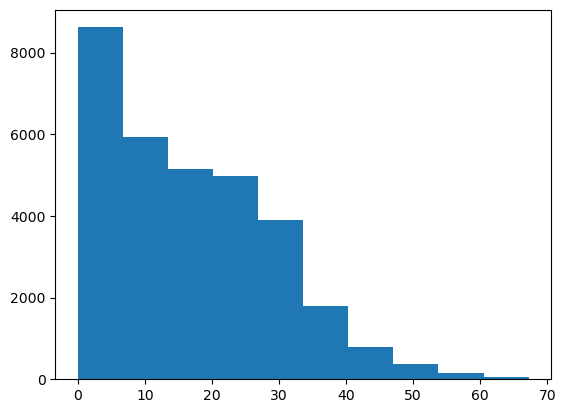

In [144]:
plt.hist(pos_gaps)